In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx

<Axes: >

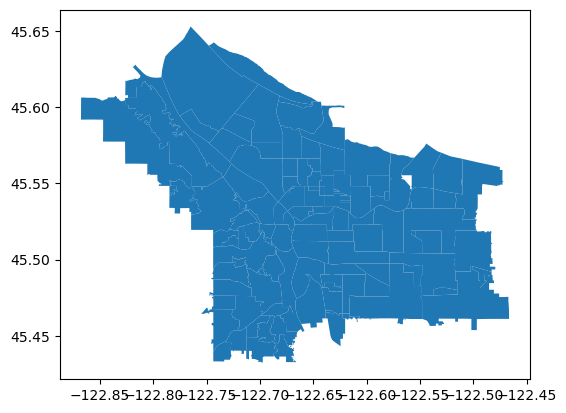

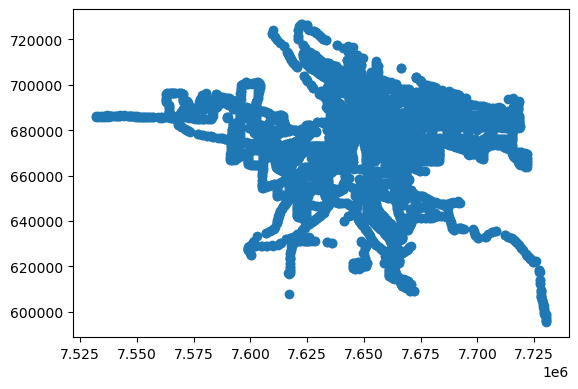

In [2]:
portland_boundaries = gpd.read_file('data/neighborhood_boundaries.geojson')
portland_boundaries.plot()
trimet_stops = gpd.read_file('data/tm_stops.shp')
trimet_stops.plot()

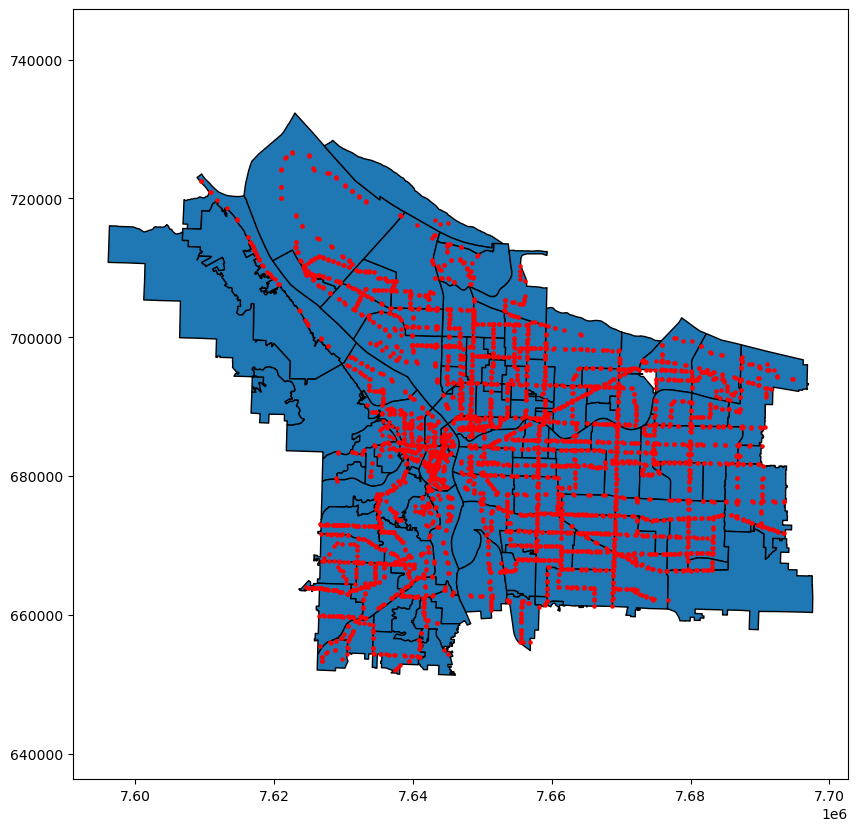

In [3]:
projected_crs = 'EPSG:2913'
portland_proj = portland_boundaries.to_crs(projected_crs)
trimet_proj = trimet_stops.to_crs(projected_crs)
stops_in_pdx = gpd.sjoin(
    trimet_proj,
    portland_proj,
    how='inner',
    predicate='intersects'
)

ax = portland_proj.plot(figsize=(10, 10), edgecolor="black")
stops_in_pdx.plot(ax=ax, color="red", markersize=5)

plt.axis("equal")
plt.show()

In [4]:
# Get a count of stops per neighborhood using map label column from neighborhood data
stops_per_nbhd = (
    stops_in_pdx
    .groupby("MAPLABEL")
    .size()
    .reset_index(name='stop_count')
)

In [5]:
combined_data = portland_proj.merge(
    stops_per_nbhd,
    on="MAPLABEL",
    how='left',
).fillna({'stop_count':0})

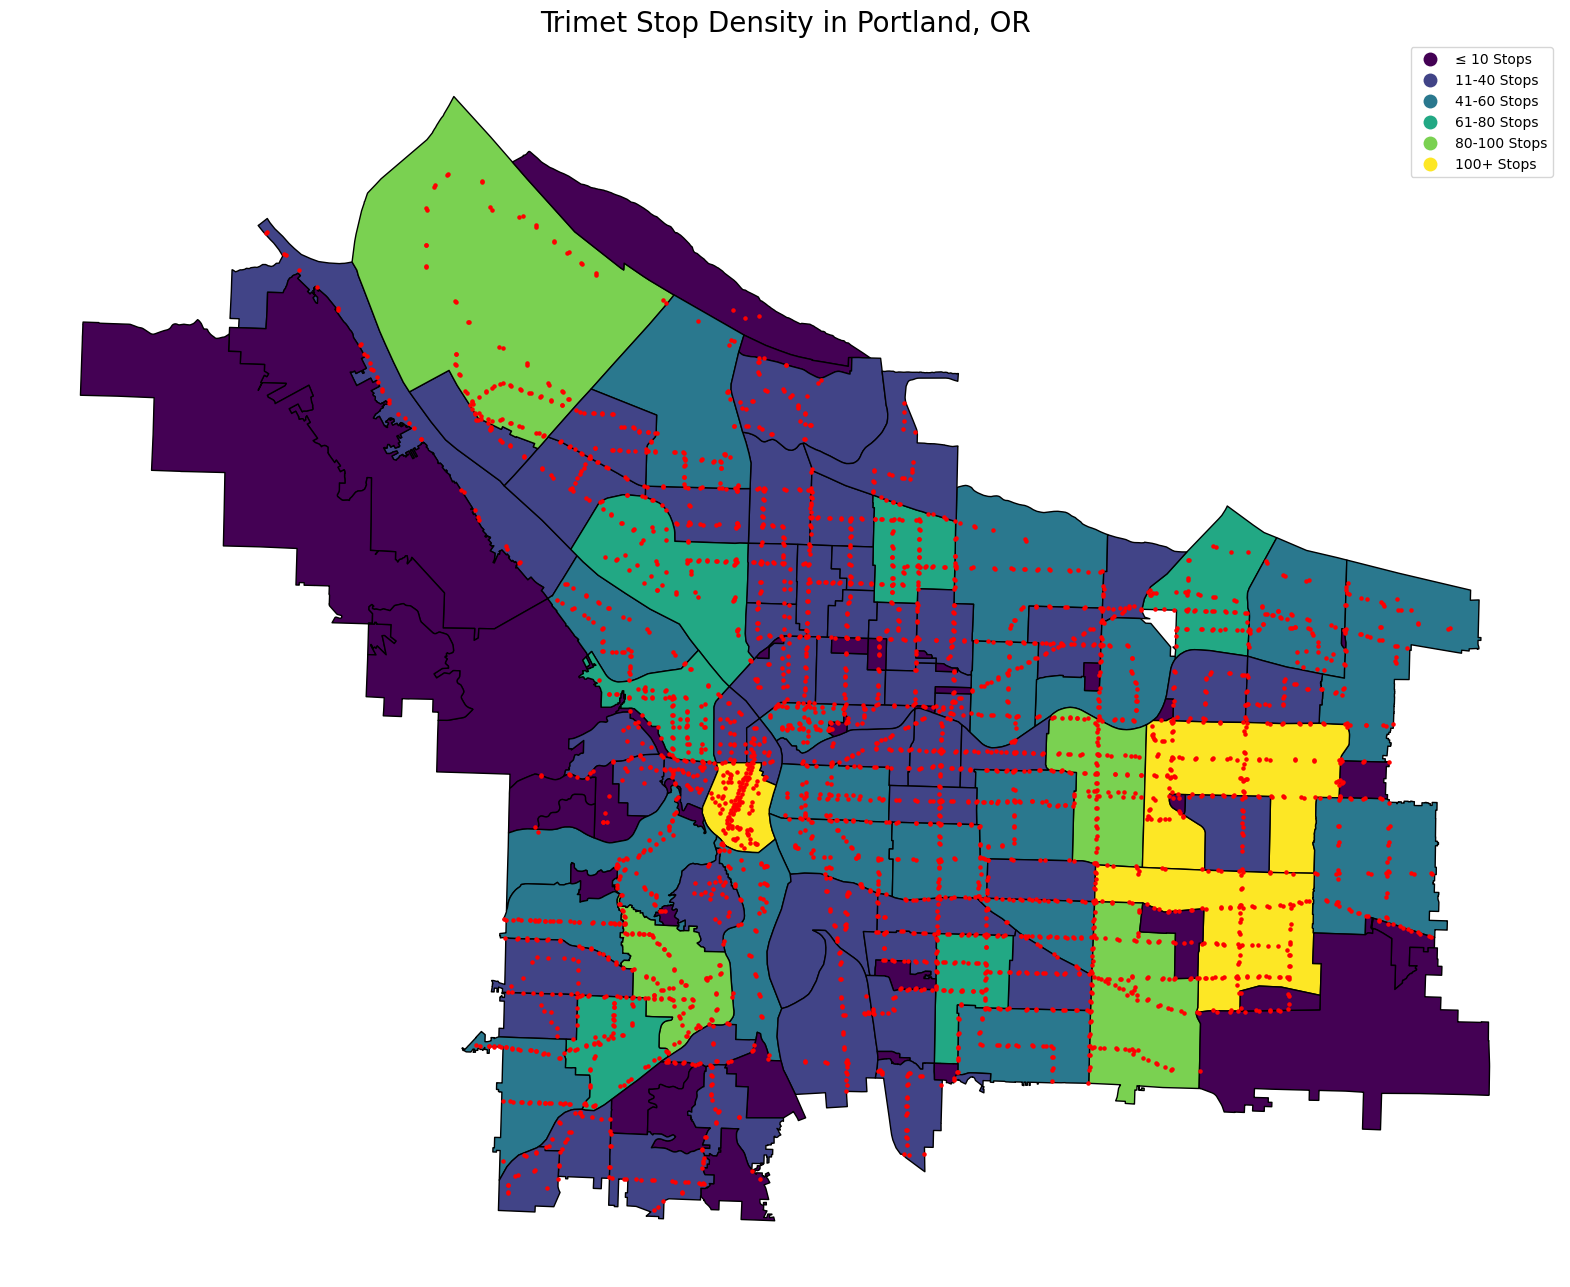

In [6]:
stops_in_pdx = gpd.sjoin(
    trimet_proj,
    combined_data,
    how='inner',
    predicate='intersects'
)

bins = [0, 10, 40, 60, 80, 100, float("inf")]
labels = [
    "≤ 10 Stops",
    "11-40 Stops",
    "41-60 Stops",
    "61-80 Stops",
    "80-100 Stops",
    "100+ Stops"
]

combined_data["stop_count_bucket"] = pd.cut(
    combined_data["stop_count"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)


ax = combined_data.plot(figsize=(20,20), edgecolor="black", column='stop_count_bucket',  cmap='viridis', legend=True)
stops_in_pdx.plot(ax=ax, color="red", markersize=5)
plt.title('Trimet Stop Density in Portland, OR', fontsize=20)

plt.axis("off")
plt.savefig('charts/stop_density.png')
plt.show()

In [7]:
portland_network = ox.graph_from_place(
    "Portland, Oregon, USA",
    network_type='walk'
)

Use OSMNX to plot where buses stop in Portland

In [8]:
G = ox.project_graph(portland_network)

Use OSMNX to match a node per neighborhood to the neighborhood center to calculate avg. walking distance

In [9]:
combined_data = combined_data.to_crs(G.graph["crs"])

combined_data['centroid'] = combined_data["geometry"].centroid

combined_data['node'] = ox.distance.nearest_nodes(
    G,
    combined_data['centroid'].x,
    combined_data['centroid'].y
)

In [10]:
stops_in_pdx = stops_in_pdx.to_crs(G.graph["crs"])

stops_in_pdx['centroid'] = stops_in_pdx["geometry"].centroid

stops_in_pdx['node'] = ox.distance.nearest_nodes(
    G,
    stops_in_pdx['centroid'].x,
    stops_in_pdx['centroid'].y
)

In [11]:
display(stops_in_pdx.head())

,stop_id,stop_name,jurisdic,zipcode,type,geometry,index_right,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Length,MAPLABEL,ID,stop_count,centroid,node
7,7414,SW 35th & California,Portland,97219,BUS,POINT (522437.448 5035741.876),100,101,MULTNOMAH,SOUTHWEST,N,SWCS,HORZ,13290.653703,Multnomah,101,61.0,POINT (522437.448 5035741.876),40438856
8,1955,SW Garden Home & 42nd,Portland,97219,BUS,POINT (521848.816 5034798.478),100,101,MULTNOMAH,SOUTHWEST,N,SWCS,HORZ,13290.653703,Multnomah,101,61.0,POINT (521848.816 5034798.478),40646509
14,8373,Hollywood/NE 42nd Ave MAX Station,Portland,97232,MAX,POINT (529563.006 5042228.215),43,44,HOLLYWOOD,,N,CNN,HORZ,4262.703048,Hollywood,44,17.0,POINT (529563.006 5042228.215),2278640973
17,5230,NE Shaver & 112th,Portland,97220,BUS,POINT (535307.035 5044340.213),12,13,PARKROSE,,N,EPCO,HORZ,15199.542307,Parkrose,13,61.0,POINT (535307.035 5044340.213),7147910486
18,6722,NE 135th & Rose Parkway,Portland,97230,BUS,POINT (537188.18 5043681.728),14,15,ARGAY TERRACE,,N,EPCO,VERT,13252.062099,Argay Terrace,15,54.0,POINT (537188.18 5043681.728),40539784


In [12]:
stop_nodes = set(stops_in_pdx["node"])

lengths = nx.multi_source_dijkstra_path_length(
    G,
    sources=stop_nodes,
    weight="length"   # meters
)

In [13]:
combined_data["walk_dist_m"] = combined_data["node"].map(
    lambda n: lengths.get(n, float("inf"))
)

In [14]:
combined_data["walk_time_min"] = combined_data["walk_dist_m"] / 80

bins = [0, 5, 10, 20, float("inf")]
labels = [
    "≤ 5 min",
    "5–10 min",
    "10–20 min",
    "20+ min"
]

combined_data["walk_time_bucket"] = pd.cut(
    combined_data["walk_time_min"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

In [15]:
display(combined_data)

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Length,MAPLABEL,ID,geometry,stop_count,stop_count_bucket,centroid,node,walk_dist_m,walk_time_min,walk_time_bucket
0,1,LINNTON,,N,NWNW,HORZ,53244.045538,Linnton,1,"POLYGON ((515684.454 5051787.068, 515524.492 5...",36.0,11-40 Stops,POINT (517485.626 5048660.88),1383417585,109.660592,1.370757,≤ 5 min
1,2,FOREST PARK/LINNTON,,Y,NWNW,None,57723.635350,Forest Park/Linnton,2,"POLYGON ((513787.545 5050305.496, 513747.148 5...",0.0,≤ 10 Stops,POINT (517025.882 5047477.076),1214189766,1754.466528,21.930832,20+ min
2,3,FOREST PARK,,N,NWNW,HORZ,82725.497522,Forest Park,3,"POLYGON ((516268.709 5043897.792, 516325.255 5...",1.0,≤ 10 Stops,POINT (516228.467 5045669.889),8231065306,3472.674756,43.408434,20+ min
3,4,CATHEDRAL PARK,,N,NPNS,HORZ,11434.254777,Cathedral Park,4,"POLYGON ((518362.864 5047987.762, 518617.33 50...",15.0,11-40 Stops,POINT (518930.816 5048231.571),40735807,271.009968,3.387625,≤ 5 min
4,5,UNIVERSITY PARK,,N,NPNS,HORZ,11950.859827,University Park,5,"POLYGON ((520395.714 5047856.199, 520202.115 5...",26.0,11-40 Stops,POINT (521059.536 5047014.672),12164214142,87.979046,1.099738,≤ 5 min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,121,KENTON,ALBINA,N,NPNS,HORZ,19247.188225,Kenton,126,"POLYGON ((525076.331 5047124.948, 525079.053 5...",47.0,41-60 Stops,POINT (523602.095 5049056.472),40585417,954.586905,11.932336,10–20 min
121,122,BRIDGETON,,N,NPNS,HORZ,8635.720662,Bridgeton,127,"POLYGON ((526745.767 5049929.252, 526597.895 5...",2.0,≤ 10 Stops,POINT (525887.106 5049991.507),40463887,228.588462,2.857356,≤ 5 min
122,123,EAST COLUMBIA,,N,NPNS,HORZ,15397.269131,East Columbia,128,"POLYGON ((526504.247 5049604.548, 526484.298 5...",38.0,11-40 Stops,POINT (526373.115 5048984.032),40550541,281.818332,3.522729,≤ 5 min
123,124,SUNDERLAND,,N,CNN,HORZ,20706.496916,Sunderland,129,"POLYGON ((528051.151 5049797.77, 528001.197 50...",26.0,11-40 Stops,POINT (528350.888 5047878.069),4317336896,394.000692,4.925009,≤ 5 min


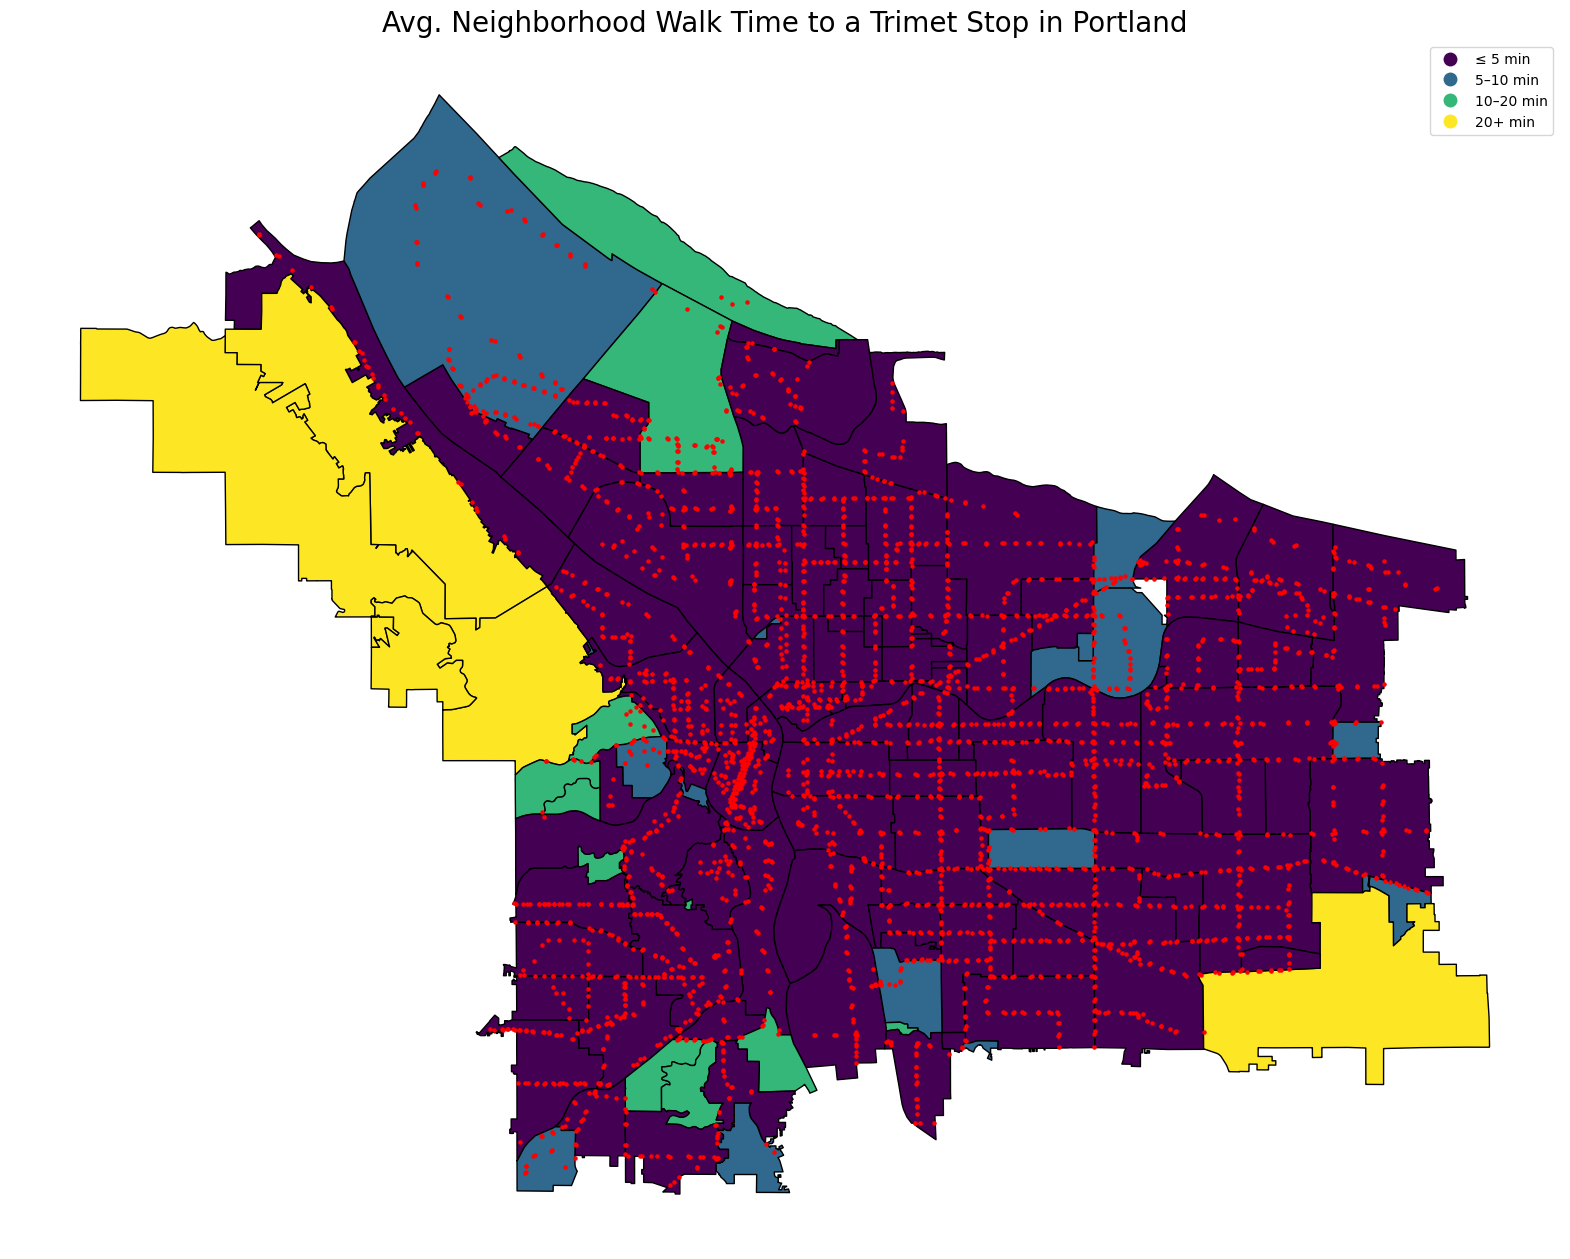

In [17]:
ax = combined_data.plot(figsize=(20,20), edgecolor="black", column='walk_time_bucket', cmap='viridis', legend=True)
stops_in_pdx.plot(ax=ax, color="red", markersize=5)

plt.title('Avg. Neighborhood Walk Time to a Trimet Stop in Portland', fontsize=20)
plt.axis("off")
plt.savefig('charts/neighborhood_walk_time.png')
plt.show()